<a href="https://colab.research.google.com/github/Jingut/EX/blob/main/Exp_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done


In [2]:
!apt-get install g++ openjdk-8-jdk 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
openjdk-8-jdk is already the newest version (8u342-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [3]:
!pip3 install konlpy JPype1-py3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기


# 라이브러리 버전을 확인

In [5]:
import pandas
import konlpy
import gensim
import numpy as np
import tensorflow as tf
import os

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


In [6]:
!git clone https://github.com/e9t/nsmc

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [7]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# 코랩 GPU로 학습이 안될 때 설치해야 할것

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


#1) 데이터 준비와 확인

In [8]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/nsmc/ratings_train.txt')
test_data = pd.read_table('/content/nsmc/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#2) 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거

* NaN 결측치 제거

* 한국어 토크나이저로 토큰화

* 불용어(Stopwords) 제거

* 사전word_to_index 구성

* 텍스트 스트링을 사전 인덱스 스트링으로 
변환


* X_train, y_train, X_test, y_test, 

* word_to_index 리턴

In [9]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포

* 적절한 최대 문장 길이 지정

* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [11]:
#데이터셋 내 문장 길이 분포
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [12]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [13]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# 4) 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

lstm, maxpool추가등


In [15]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

np.random.seed(0)
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)


model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [16]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 


model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 3488      
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [17]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 
np.random.seed(0)

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(tf.keras.layers.MaxPooling1D(5))
model3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          11216     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                

In [18]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


#5) 모델 훈련 개시


In [19]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size= 512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 5ms/step - loss: 0.4763 - accuracy: 0.8003 - val_loss: 0.3491 - val_accuracy: 0.8474
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3200 - accuracy: 0.8654 - val_loss: 0.3313 - val_accuracy: 0.8553
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2767 - accuracy: 0.8866 - val_loss: 0.3333 - val_accuracy: 0.8557
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2419 - accuracy: 0.9045 - val_loss: 0.3431 - val_accuracy: 0.8554
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2088 - accuracy: 0.9202 - val_loss: 0.3589 - val_accuracy: 0.8544
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1756 - accuracy: 0.9361 - val_loss: 0.3827 - val_accuracy: 0.8522
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.1437 - accuracy: 0.9507 - val_loss: 0.4129 - val_accuracy: 0.8463
Epoch 

In [20]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size= 512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 8ms/step - loss: 0.5423 - accuracy: 0.7780 - val_loss: 0.4753 - val_accuracy: 0.8426
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.4461 - accuracy: 0.8542 - val_loss: 0.4389 - val_accuracy: 0.8483
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.4008 - accuracy: 0.8675 - val_loss: 0.4227 - val_accuracy: 0.8435
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3651 - accuracy: 0.8787 - val_loss: 0.4052 - val_accuracy: 0.8458
Epoch 5/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3352 - accuracy: 0.8877 - val_loss: 0.4034 - val_accuracy: 0.8465
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3090 - accuracy: 0.8969 - val_loss: 0.3994 - val_accuracy: 0.8470
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2856 - accuracy: 0.9053 - val_loss: 0.4073 - val_accuracy: 0.8501
Epoch 

In [21]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size= 512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 7ms/step - loss: 0.4466 - accuracy: 0.7801 - val_loss: 0.3320 - val_accuracy: 0.8558
Epoch 2/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2979 - accuracy: 0.8746 - val_loss: 0.3203 - val_accuracy: 0.8616
Epoch 3/20
266/266 [==============================] - 1s 6ms/step - loss: 0.2404 - accuracy: 0.9036 - val_loss: 0.3345 - val_accuracy: 0.8582
Epoch 4/20
266/266 [==============================] - 1s 6ms/step - loss: 0.1748 - accuracy: 0.9341 - val_loss: 0.3793 - val_accuracy: 0.8545
Epoch 5/20
266/266 [==============================] - 1s 6ms/step - loss: 0.1141 - accuracy: 0.9608 - val_loss: 0.4618 - val_accuracy: 0.8480
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.0746 - accuracy: 0.9759 - val_loss: 0.5407 - val_accuracy: 0.8419
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.0517 - accuracy: 0.9839 - val_loss: 0.6582 - val_accuracy: 0.8376
Epoch 

# 6) Loss, Accuracy 그래프 시각화

In [22]:
results = model1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.8698 - accuracy: 0.8264 - 2s/epoch - 2ms/step
[0.869762659072876, 0.8263522982597351]


In [23]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.6023 - accuracy: 0.8383 - 4s/epoch - 2ms/step
[0.6022540926933289, 0.838334321975708]


In [24]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.2971 - accuracy: 0.8282 - 3s/epoch - 2ms/step
[1.2971341609954834, 0.8281831741333008]


In [25]:
history_dict1 = history1.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [26]:
history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [27]:
history_dict3 = history3.history
print(history_dict3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


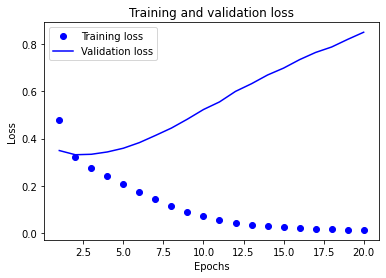

In [28]:
import matplotlib.pyplot as plt

acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

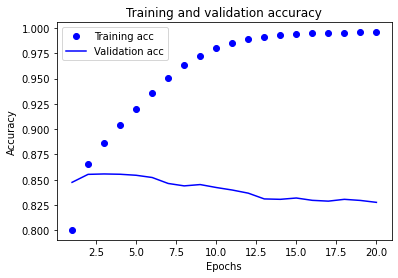

In [29]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

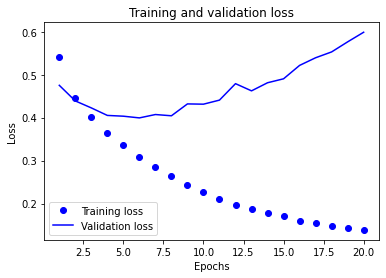

In [30]:
import matplotlib.pyplot as plt

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

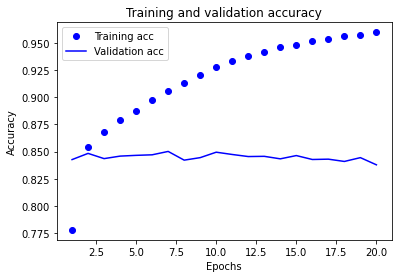

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

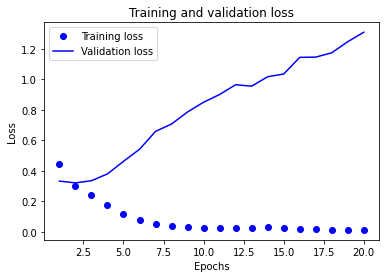

In [32]:
import matplotlib.pyplot as plt

acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

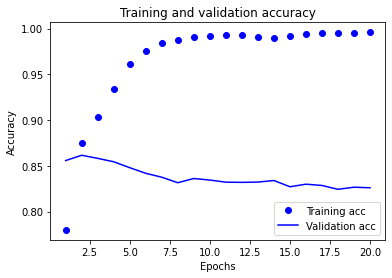

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [35]:
embedding_layer = model2.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [36]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


# 7) 학습된 Embedding 레이어 분석

# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선


Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있습니다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미해지게 마련입니다.

In [37]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
index_to_word = {index:word for word, index in word_to_index.items()}
word_to_index={word:index for index, word in index_to_word.items()}
word2vec_file_path = '/content/drive/MyDrive/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
  f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.02937589, -0.04668761, -0.0947912 ,  0.00767936,  0.05843323,
        0.03356896,  0.02784698, -0.10052253, -0.0651691 , -0.02464988,
        0.06530337, -0.08576927,  0.01302151,  0.03441633, -0.07046764,
        0.14727192, -0.09707151, -0.02969913, -0.10394479,  0.10588142,
        0.11786158, -0.1526451 ,  0.0290927 ,  0.09427416,  0.00069363,
        0.06164145,  0.2362021 , -0.12186397,  0.0657955 , -0.14134865,
       -0.092127  , -0.01817951,  0.13231273,  0.0067181 , -0.08135489,
        0.14529142,  0.09347849,  0.08237743,  0.11492696,  0.0377064 ,
       -0.02664603,  0.11119869, -0.10306221,  0.10109679,  0.13027954,
       -0.04847882,  0.10329013,  0.09158485, -0.02621144,  0.17557147,
       -0.09543051, -0.04621815,  0.15545857,  0.14638951, -0.14857325,
        0.00755917,  0.04941008,  0.02961294,  0.03881631, -0.08254969,
       -0.06599111,  0.04039842,  0.11393145,  0.05218324, -0.06747057,
       -0.0589841 ,  0.0399221 , -0.08553416,  0.06125595, -0.07

In [39]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
word_vectors.similar_by_word("사랑")

[('스콧', 0.8465864062309265),
 ('귓가', 0.8168860077857971),
 ('준다면', 0.8121400475502014),
 ('강렬', 0.8079788088798523),
 ('짠', 0.8052635192871094),
 ('훌륭', 0.8034086227416992),
 ('네티즌', 0.8004252910614014),
 ('디테일', 0.8000178337097168),
 ('아름다운', 0.7959952354431152),
 ('한꺼번에', 0.7955772280693054)]

In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path1 = '/content/drive/MyDrive/word2vec(kor)/word2vec_ko.model'
word_vectors1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path1, binary=False)
vector1 = word_vectors1.wv['사랑']
vector1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


array([ 0.02530968,  0.05852872,  0.08988379, -0.14168385, -0.08940731,
       -0.15185645,  0.10761441, -0.05632664, -0.18238729, -0.14914452,
        0.07174833, -0.1472937 , -0.0054911 , -0.12119484, -0.01314659,
        0.1407486 ,  0.15253563,  0.03373742,  0.16463675, -0.01106343,
        0.07673444, -0.11160018, -0.04351185,  0.12755266,  0.18100742,
       -0.17174454, -0.22629628,  0.03327921,  0.03827739, -0.11863233,
        0.02637341,  0.04085022,  0.22652847,  0.16345575,  0.01043751,
        0.14025016,  0.07280126, -0.04691   , -0.02013588, -0.10701713,
       -0.079561  , -0.1755658 ,  0.10289974, -0.06251051, -0.03072437,
       -0.00822033,  0.09061726,  0.08657675, -0.08914933, -0.06724706,
       -0.09252636, -0.1589538 , -0.13363229, -0.04384868, -0.05100388,
        0.06497974,  0.00966329, -0.00313258,  0.07813603, -0.11148603,
        0.03293246,  0.14905268,  0.09778181, -0.176283  , -0.18993294,
        0.05779038,  0.08356206,  0.0297687 , -0.07800542, -0.01

In [42]:
word_vectors1.similar_by_word("사랑")

[('깊', 0.8771204948425293),
 ('시즌', 0.8445206880569458),
 ('릿', 0.8442276120185852),
 ('100', 0.844045877456665),
 ('주행', 0.8333005309104919),
 ('저런', 0.8233494162559509),
 ('느꼈', 0.8167331218719482),
 ('떠서', 0.8108041286468506),
 ('생각나', 0.8091479539871216),
 ('졌으면', 0.8072594404220581)]

In [43]:
import numpy as np
#word_to_index = model2.get_word_index()
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [44]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(tf.keras.layers.MaxPooling1D(5))
model4.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(tf.keras.layers.GlobalMaxPooling1D())
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 16)            11216     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 16)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 8)                

In [45]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model5 = tf.keras.Sequential()
model5.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model5 = tf.keras.Sequential()
model5.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model5.add(tf.keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
#model5.add(tf.keras.layers.Dense(8, activation='relu'))
model5.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm_1 (LSTM)               (None, 256)               365568    
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,365,825
Trainable params: 1,365,825
Non-trainable params: 0
_________________________________________________________________


In [46]:
from tensorflow.keras.initializers import Constant
import tensorflow as tf
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model6 = tf.keras.Sequential()
model6.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model6 = tf.keras.Sequential()
model6.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model6.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model6.add(tf.keras.layers.MaxPooling1D(5))
model6.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model6.add(tf.keras.layers.GlobalMaxPooling1D())
model6.add(tf.keras.layers.Dense(8, activation='relu'))
model6.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 100)         1000000   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 16)          11216     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 8)                

In [47]:
# 학습의 진행
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 2s 6ms/step - loss: 0.3891 - accuracy: 0.8285 - val_loss: 0.3462 - val_accuracy: 0.8517
Epoch 2/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2778 - accuracy: 0.8880 - val_loss: 0.3472 - val_accuracy: 0.8541
Epoch 3/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2406 - accuracy: 0.9068 - val_loss: 0.3552 - val_accuracy: 0.8510
Epoch 4/5
266/266 [==============================] - 1s 6ms/step - loss: 0.2098 - accuracy: 0.9213 - val_loss: 0.3760 - val_accuracy: 0.8530
Epoch 5/5
266/266 [==============================] - 1s 6ms/step - loss: 0.1765 - accuracy: 0.9369 - val_loss: 0.4099 - val_accuracy: 0.8480


In [48]:
# 학습의 진행
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model5.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 8s 23ms/step - loss: 0.4099 - accuracy: 0.8098 - val_loss: 0.3406 - val_accuracy: 0.8497
Epoch 2/5
266/266 [==============================] - 6s 21ms/step - loss: 0.3194 - accuracy: 0.8640 - val_loss: 0.3273 - val_accuracy: 0.8539
Epoch 3/5
266/266 [==============================] - 6s 21ms/step - loss: 0.2844 - accuracy: 0.8799 - val_loss: 0.3166 - val_accuracy: 0.8609
Epoch 4/5
266/266 [==============================] - 6s 21ms/step - loss: 0.2562 - accuracy: 0.8937 - val_loss: 0.3218 - val_accuracy: 0.8641
Epoch 5/5
266/266 [==============================] - 6s 21ms/step - loss: 0.2318 - accuracy: 0.9051 - val_loss: 0.3334 - val_accuracy: 0.8581


In [49]:
# 학습의 진행
model6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model6.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 2s 6ms/step - loss: 0.4430 - accuracy: 0.7919 - val_loss: 0.3372 - val_accuracy: 0.8554
Epoch 2/5
266/266 [==============================] - 2s 6ms/step - loss: 0.3066 - accuracy: 0.8708 - val_loss: 0.3292 - val_accuracy: 0.8554
Epoch 3/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2583 - accuracy: 0.8953 - val_loss: 0.3348 - val_accuracy: 0.8565
Epoch 4/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2025 - accuracy: 0.9232 - val_loss: 0.3621 - val_accuracy: 0.8560
Epoch 5/5
266/266 [==============================] - 1s 6ms/step - loss: 0.1436 - accuracy: 0.9491 - val_loss: 0.4100 - val_accuracy: 0.8519


In [50]:
# 테스트셋을 통한 모델 평가
results = model4.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4195 - accuracy: 0.8419 - 3s/epoch - 2ms/step
[0.41946670413017273, 0.841853678226471]


In [51]:
# 테스트셋을 통한 모델 평가
results = model5.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3414 - accuracy: 0.8566 - 4s/epoch - 3ms/step
[0.3414194881916046, 0.85658198595047]


In [52]:
# 테스트셋을 통한 모델 평가
results = model6.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4196 - accuracy: 0.8483 - 3s/epoch - 2ms/step
[0.4195839762687683, 0.8483023643493652]


한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.


한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 

참고 링크1 : https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models

참고 링크2 :https://radimrehurek.com/gensim/models/keyedvectors.html

#결론

이번 프로젝트에서는 네이버 영화리뷰 데이터를 받아와서 감성분석을 해보는 프로젝트를 진행해보았습니다.

각각 3개의 모델을 구성하여 결과를 출력해보았고.
word2vec임베딩을 이용하여 하나의 키워드를 지정하면 그에 맞는 관련 키워드를 출력해보고 자체학습 혹은 사전학습된 임베딩 레이어를 분석 해보았습니다.



# 회고

---



## - 이번 프로젝트에서 어려웠던 점

이번 프로젝트에서 어려웠던 점은 데이터 자체 전처리가 많아서 까다로웠습니다 그리고 모델구성도 다양하게 구성해보아야했고 텍스트 스트링을 인덱스 스트링으로 변환하는 부분도 쉽지 않았습니다. 그리고 한국어 데이터셋을 받아올 때 LMS와 다르게 데이터를 로드하는 방법이 달랐고 이번 학습은 런타임을 GPU를 이용하여 돌렸을 때 오류가 발생하는 이슈도 있었습니다.

그리고 사전학습되지 않은 word2vec과 사전학습이된 word2vec에 같은 키워드를 할당했을 때 사전학습이 된 것의 결과물이 키워드와 연관성이 높은 단어들이 많이 추출되었습니다.


---


## - 프로젝트를 진행하면서 알게된 점
- 이번에 프로젝트를 진행하면서 런타임을 GPU로 설정하면  모델 학습이 되지 않는 이슈가 있었는데 아래의 코드를 실행해주면 정상적으로 진행이 되고 
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2


- 에포크를 많이 지정할수록 학습의 결과가 좋다고 생각했었는데 이번에는 많이 학습을 시킬수록 다시 학습률이 떨어지는 경우가 발생해서 적당한 에포크 수를 지정해주는 것이 좋다는 것을 알았습니다.

- 이번에는 훈련데이터셋을 분리할 때 패딩을 post가 아닌 pre로 설정해주었는데 저번 프로젝트에서는 post가 이론과는 다르게 pre패딩보다 결과가 좋았었는데
이번에는 pre로 설정해주었더니 전반적으로 post보다 학습결과가 조금 더 좋게 나왔습니다.

---


## - 루브릭 평가지표를 맞추기 위해 시도한 것들

- 학습데이터 패딩을 pre, post등으로 바꾸어서 학습성능을 비교해보았습니다.

- 네이버 영화리뷰 데이터 감성분석 정확도를 85%이상 달성하기 위해 배치사이즈를 조절해보았고 모델 5번에서 LSTM의 입력값을 늘려주었고 아래쪽의 Dense층의 활성화 함수가 relu함수인 층을 제거해보고 돌려보았습니다.

- 20에포크 기준으로 가장 정확도가 높았던 에포크를 찾아보았고 그에 맞게 에포크를 조절해주었습니다

---


## - 자기다짐

- 아직 데이터 전처리 부분이나 코드적인 이해가 많이 부족한듯하여 목요일마다 진행중인 캐글필사를 좀 더 적극적으로 해보아야겠다고 생각했습니다.

- 모델학습 전에 데이터를 뜯어보는 습관을 가져야 할 것 같다고 생각했습니다.

- 모델의 파라미터만 조절해서 학습성능을 올리기보다는 이제는 모델의 구조도 만져보는 시도를 해보아야 할 것 같다고 생각했습니다.

